## Numerical Methods In Finance | fall 2024


### *Test*

Please send your file to **vantipov@nes.ru** with topic **"NMF 2024 - Test - Surname"**. Please also rename your file as **"Surname_NMF2024_Test.ipynb"** before sending. If your answer contains many files, please add them to archive (e.g. use zip format) with the same name as the main file.

If you have any questions feel free to ask in Telegram in the group chat.

### 1. Salvaging a linear correlation matrix

You are given a correlation matrix estimated by the historical returns on the following equity stocks **SBER, YDEX, T, MGNT**:

$$\text{C} = \begin{pmatrix} 1 & 0.78 & 0.8 & 0.45 \\ 0.78 & 1 & 0.75 & 0.9 \\ 0.8 & 0.75 & 1 & 0.85 \\ 0.45 & 0.9 & 0.85 & 1 \end{pmatrix}$$

Unfortunately, this correlation matrix is not positive-semidefinite.

On the seminar you faced with two algorithms, based on **hypersphere** and **spectral** decompositions, providing the way on how to adjust a correlation matrix to make it positive-semidefinite. Each of these algorithms have their own pros and cons. Your task is to combine these approaches to construct the new and the best one.

Implement the following algorithm:

1. Apply a **spectral** decomposition algorithm, that is construct a symmetrix positive-definite matrix $\widetilde{\text{C}} = \text{B} \cdot \text{B}^T. $

2. Apply Cholesky decomposition to matrix $\widetilde{\text{C}} = \text{L} \cdot \text{L}^{T}$. 

3. Use matrix $\text{L}$ as an initial guess for the **hyphersphere** decomposition $\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^T$ with reduced number of $\frac{n(n-1)}{2}$ angles, constructed with an optimization procedure.

Your answer should contatin the resulting matrix $\widetilde{\text{C}}$ and the $L_2$ norm between it and the original one. Does this combo-algorithm performs better than each of the algorithms separately?

In [1]:
import numpy as np
import copy
import scipy
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Optional, Iterable, Callable, Dict, Union

from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vectorized = np.vectorize(implied_volatility)

In [2]:
def B(theta: np.ndarray):
    cosine_B = np.cos(theta)
    cosine_B_shifted = np.c_[cosine_B, np.ones(cosine_B.shape[0])]
    sin_B = np.sin(theta)
    sin_B_shifted = np.c_[np.ones(sin_B.shape[0]), sin_B]
    sin_B_shifted_cumprod = np.cumprod(sin_B_shifted, axis=-1)
    return cosine_B_shifted * sin_B_shifted_cumprod


def reshape_theta_to_appropriate_size(theta: np.ndarray, n: int):
    theta_size = theta.shape[0]
    rows_dim = int(n)
    cols_dim = int(theta_size / rows_dim)
    return theta.reshape(rows_dim, cols_dim)


def l2_norm(theta: np.ndarray, C: np.ndarray):
    theta = reshape_theta_to_appropriate_size(theta=theta, n=C.shape[0])
    B_new = B(theta)
    C_approx = B_new @ B_new.T
    return np.linalg.norm(C_approx - C, ord='fro')


def truncate_negative_eigen_values(L: np.ndarray):
    L_ = copy.deepcopy(L)
    L_[np.diag_indices_from(L_)] = np.maximum(np.diag(L_), 0)
    return L_


def scaling_matrix(Q: np.ndarray, L_: np.ndarray):
    return np.diag(1 / np.sum(Q * Q * np.diag(L_), axis=1))


def get_correlation_matrix_for_spectral(C: np.ndarray):
    L, Q = scipy.linalg.schur(C)

    L_ = truncate_negative_eigen_values(L)
    T = scaling_matrix(Q, L_)

    B = np.sqrt(T) @ Q @ np.sqrt(np.abs(L_))
    result = B @ B.T
    for i in range(len(result)):
        result[i][i] = 1.0
    return result


def get_correlation_matrix_for_hyperspace(
    C: np.ndarray,
    n: int,
    theta: np.ndarray
):
    res = minimize(fun=l2_norm, x0=theta, args=C, method="BFGS")
    theta_opt = res.x
    theta_opt_reshaped = reshape_theta_to_appropriate_size(
        theta=theta_opt,
        n=n
    )
    C_approx_opt = B(theta_opt_reshaped) @ B(theta_opt_reshaped).T

    return C_approx_opt


def get_correlation_matrix_for_combo(C: np.ndarray, n: int):
    def get_theta(L: np.ndarray):
        N = L.shape[0]
        theta = np.zeros((N, N))

        for i in range(N):
            theta[i][0] = np.arccos(L[i][0])
            for j in range(1, N):
                prod = 1
                for k in range(j - 1):
                    prod *= np.sin(theta[i][k])
                if np.abs(prod) > 1e-12:
                    theta[i][j] = np.arccos(L[i][j] / prod)
                else:
                    theta[i][j] = 0
        return theta[:, :-1]

    C_approx_spec_decomp = get_correlation_matrix_for_spectral(C)
    N = C_approx_spec_decomp.shape[0]
    for i in range(N):
        C_approx_spec_decomp[i][i] = 1

    theta = get_theta(np.linalg.cholesky(C_approx_spec_decomp)).reshape(-1)
    return get_correlation_matrix_for_hyperspace(C=C, theta=theta, n=n)

In [3]:
C = np.array([[1, 0.78, 0.8, 0.45],
             [0.78, 1, 0.75, 0.9],
             [0.8, 0.75, 1, 0.85],
             [0.45, 0.9, 0.85, 1]])

### Spectral

In [4]:
C_approx_spec_decomp = get_correlation_matrix_for_spectral(C)
print("L2 norm mimum: \n {} \n".format(
    np.linalg.norm(C_approx_spec_decomp - C, ord='fro'))
)
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via spectral decomposition with optimization: \n {} \n".format(C_approx_spec_decomp))

L2 norm mimum: 
 0.10085568871109382 

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via spectral decomposition with optimization: 
 [[1.         0.74884293 0.77233863 0.46075865]
 [0.74884293 1.         0.7541838  0.85715726]
 [0.77233863 0.7541838  1.         0.8128346 ]
 [0.46075865 0.85715726 0.8128346  1.        ]] 



### Hyphersphere

In [5]:
C_approx_hyp_decomp = get_correlation_matrix_for_hyperspace(
    C,
    theta=np.random.rand(12),
    n=4
)
print("L2 norm mimum: \n {} \n".format(
    np.linalg.norm(C_approx_hyp_decomp - C, ord='fro'))
)
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: \n {} \n".format(C_approx_hyp_decomp))

L2 norm mimum: 
 0.0905074285394292 

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via hyphersphere decomposition with optimization: 
 [[1.         0.75598858 0.77940481 0.4777886 ]
 [0.75598858 1.         0.77363051 0.86811609]
 [0.77940481 0.77363051 1.         0.82265231]
 [0.4777886  0.86811609 0.82265231 1.        ]] 



### Combo

In [6]:
C_combo = get_correlation_matrix_for_combo(C, n=4)
print("L2 norm mimum: \n {} \n".format(
    np.linalg.norm(C_combo - C, ord='fro'))
)
print("Initial symmetric matrix C: \n {} \n".format(C))
print("Positive-semidefinite matrix constructed via combo decomposition with optimization: \n {} \n".format(C_combo))

L2 norm mimum: 
 0.09050742853911695 

Initial symmetric matrix C: 
 [[1.   0.78 0.8  0.45]
 [0.78 1.   0.75 0.9 ]
 [0.8  0.75 1.   0.85]
 [0.45 0.9  0.85 1.  ]] 

Positive-semidefinite matrix constructed via combo decomposition with optimization: 
 [[1.         0.75598854 0.77940479 0.47778864]
 [0.75598854 1.         0.77363045 0.86811606]
 [0.77940479 0.77363045 1.         0.82265239]
 [0.47778864 0.86811606 0.82265239 1.        ]] 



### 2. Monte-Carlo integration

Having constructed the positive-semidefintie correlation matrix, you need to use it to price a basket option on **SBER** and **MGNT**.

The payoff of your option at expiration $T$ is 

$$\text{Payoff}(S^{SBER}_T, S^{MGNT}_T) = \left(\frac{1}{2} \left(\frac{S^{SBER}_T}{S^{SBER}_0} + \frac{S^{MGNT}_T}{S^{MGNT}_0}\right) - 100\% \right)_{+}.$$

Assume that each stock evolves as a geometric Brownian motion:

$$S^{SBER}_T = S^{SBER}_0 e^{(r - (\sigma^{SBER})^2/2)T + \sigma^{SBER} W^{SBER}_T}, \quad S^{MGNT}_T = S^{MGNT}_0 e^{(r - (\sigma^{MGNT})^2/2)T + \sigma^{MGNT} W^{MGNT}_T},$$

where $W^{SBER}_T$ and $W^{MGNT}_T$ are Brownian motions correlated with $\rho^{SBER, MGNT}$. 

The price of the option can be expressed as the following expectation

$$P = e^{-rT} \cdot \mathbb{E}^{\mathbb{Q}} [\text{Payoff}(S^{SBER}_T, S^{MGNT}_T)],$$

wich can be evaluated using Monte-Carlo algorithm.

You may assume that risk-free interest rate $r = 21\%$, the initial stock prices are $S^{SBER}_0 = 230$, $S^{MGNT}_0 = 4300$ and the volatilities are $\sigma^{SBER}_0 = 30\%$, $\sigma^{MGNT}_0 = 40\%$. The maturity of the option $T$ is equal to on year.

Your answer should contatin the plot of the price $P$ of the option as a function on number of Monte-Carlo simulations $N$. Does your algorithm converges? What is the speed of the convergence as a function of $N$? 

In [7]:
def sample_independent_uniform_variates(n_sample: int, size: int = 1, random_seed: int = 42):
    np.random.seed(random_seed)
    return np.random.rand(n_sample, size)


def cholesky_decomposition(x: np.ndarray):
    return np.linalg.cholesky(x)


def transform_gaussian_to_uniform(gaussian_sample: np.ndarray):
    return norm.cdf(gaussian_sample)


def transform_uniform_to_gaussian(uniform_sample: np.ndarray):
    return norm.ppf(uniform_sample)


def transform_to_log_norm(sample: np.ndarray):
    T = 1
    r = 0.21
    S_magn_initial = 4300
    S_sber_initial = 230
    sigma_magn = 0.3
    sigma_sber = 0.4
    result = np.zeros_like(sample)
    result[:, 0] = np.exp(r - (sigma_magn**2) / 2 + sigma_magn*sample[:, 0])
    result[:, 1] = np.exp(r - (sigma_sber**2) / 2 + sigma_sber*sample[:, 1])

    return result


def gaussian_copula(n_sample: int, corr_matrix: np.ndarray):
    size = corr_matrix.shape[0]
    sample_of_independent_uniform_variates = sample_independent_uniform_variates(
        n_sample=n_sample, size=size)
    sample_of_independent_standard_gaussian_variates = transform_uniform_to_gaussian(
        uniform_sample=sample_of_independent_uniform_variates)
    square_root_matrix = cholesky_decomposition(x=corr_matrix)
    sample_of_codependent_standard_gaussian_variates = sample_of_independent_standard_gaussian_variates @ square_root_matrix.T
    sample_of_codependent_uniform_variates = transform_gaussian_to_uniform(
        gaussian_sample=sample_of_codependent_standard_gaussian_variates
    )
    return sample_of_codependent_uniform_variates


def payoff(sample_of_gaussian_variates_1: np.ndarray, sample_of_gaussian_variates_2: np.ndarray):
    return np.mean(
        np.maximum(
            0.5*(sample_of_gaussian_variates_1 +
                 sample_of_gaussian_variates_2) - 1.0,
            0.0
        )
    )


def convergence_analysis(sample_of_codependent_gaussian_variates: np.ndarray, true_results: float):
    maximum_number_of_iterations = sample_of_codependent_gaussian_variates.shape[0]
    results = np.zeros((int(np.log2(maximum_number_of_iterations)), 1))
    for i in range(results.shape[0]):
        results[i, 0] = np.abs(
            np.exp(-0.21)*payoff(
                sample_of_gaussian_variates_1=sample_of_codependent_gaussian_variates[:2**i, 0],
                sample_of_gaussian_variates_2=sample_of_codependent_gaussian_variates[:2**i, 1]
            ) - true_results
        )
    return results

In [8]:
corr_matrix = C_combo[0::3, 0::3]
sample_of_codependent_uniform_variates = gaussian_copula(
    n_sample=2**19,
    corr_matrix=corr_matrix
)
sample_of_transformed_back_codependent_gaussian_variates = transform_to_log_norm(
    transform_uniform_to_gaussian(
        uniform_sample=sample_of_codependent_uniform_variates
    )
)

T = 1
r = 0.21
sigma_magn = 0.3
sigma_sber = 0.4

convergence_result = convergence_analysis(
    sample_of_codependent_gaussian_variates=sample_of_transformed_back_codependent_gaussian_variates,
    # true_results=0.5*(np.exp(r - (sigma_magn**2)/2) +
    #                   np.exp(r - (sigma_sber**2)/2)
    #                   )
    true_results=0
)

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/3688253627.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log_2(N)$, $N$ - number of samples")
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/3688253627.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


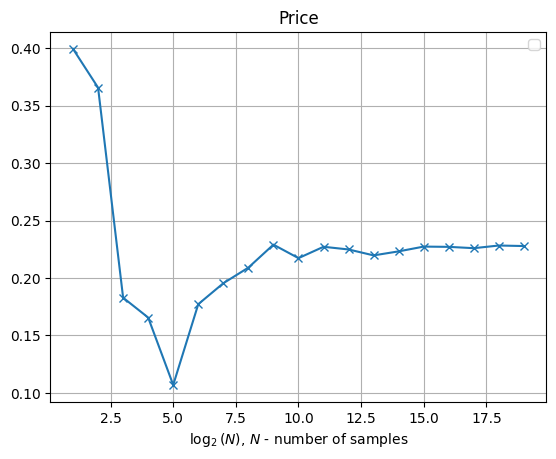

In [9]:
log_2_iteratinos = np.linspace(1, 19, 19)
plt.plot(
    log_2_iteratinos,
    convergence_result[:, 0],
    marker="x"
)
plt.title('Price')
plt.xlabel("$\log_2(N)$, $N$ - number of samples")
plt.legend()
plt.grid()
plt.show()

In [10]:
convergence_result[-1, 0]

np.float64(0.22786756364407704)

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/1072424185.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log_2(N)$, $N$ - number of samples")


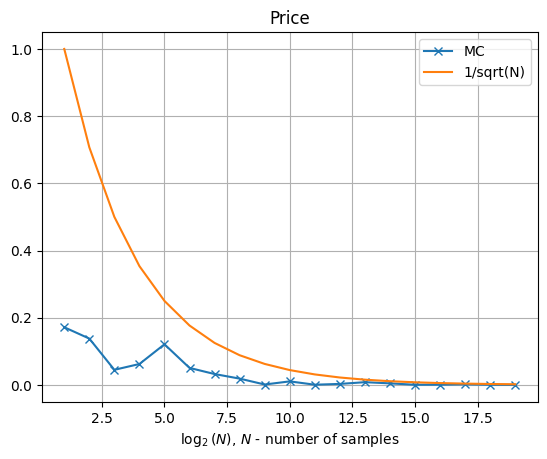

In [11]:
log_2_iteratinos = np.linspace(1, 19, 19)
one_over_sqrt_N = 1 / np.sqrt([2**i for i in range(log_2_iteratinos.shape[0])])
plt.plot(
    log_2_iteratinos,
    np.fabs(convergence_result[:, 0] - convergence_result[-1, 0]),
    marker="x"
)
plt.plot(
    log_2_iteratinos,
    one_over_sqrt_N
)
plt.title('Price')
plt.xlabel("$\log_2(N)$, $N$ - number of samples")
plt.legend(["MC", "1/sqrt(N)"])
plt.grid()
plt.show()

### 3. Implied volatilities interpolation

You are observing the following  implied volatilities for maturity $T=1$: 

$$K/S_0 = \{ 26\%, \quad 37\%, \quad 52\%, \quad 70\%, \quad 100\%, \quad 142\%, \quad 195\% \}$$
$$\sigma^{IV} = \{ 42.5\%, \quad 37.5\%, \quad 32.5\%, \quad 28.5\%, \quad 25\%, \quad 23\%, \quad 22\% \}$$

Assume that the risk-free interest rate is zero and the spot $S_0 = 1$.

Provide an interpolation algorithm (cubic splines, rational cubic splines or whatever you want) for the given implied volatilities. You **can not** use any algorithms built into scipy, numpy, or any other python module - use your one realization! Is your interpolation free of monotonicity ($C'(K) < 0$) and butterfly ($C''(K) > 0$) arbitrage? Your answer should contain a plot with interpolated implied volatilities as well as a numerical check that your interpolation does not violate no-arbitrage conditions described above. 

In [12]:
moneyness_wide_range = np.array([26, 37, 52, 70, 100, 142, 195]) / 100.
vol_wide_range = np.array([42.5, 37.5, 32.5, 28.5, 25, 23, 22]) / 100.

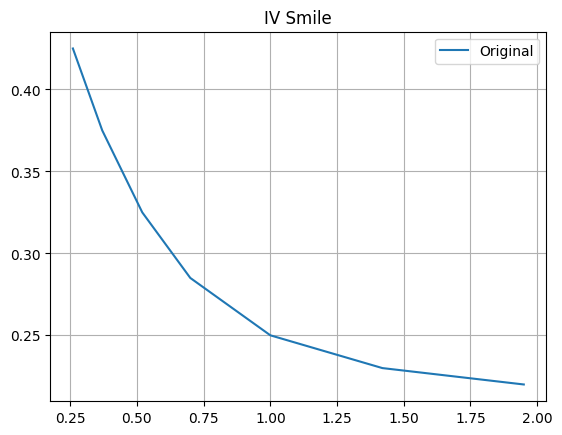

In [13]:
plt.plot(
    moneyness_wide_range,
    vol_wide_range
)
plt.title('IV Smile')
plt.xlabel("")
plt.legend(["Original"])
plt.grid()
plt.show()

In [14]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float],
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))


def monotonicity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(len(c) - 1):
        if c[i + 1] >= c[i]:
            print("A monotonicity arbitrage was detected with strikes {} and {}".format(
                k[i], k[i+1]))
            arbitrage_detected = True

    if not arbitrage_detected:
        print("No arbitrage was detected.")


def convexity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(1, len(c) - 1):
        check_to = c[i-1] / (k[i] - k[i-1]) - c[i] * (1/(k[i] -
                                                         k[i-1]) + 1/(k[i+1] - k[i])) + c[i+1] / (k[i+1] - k[i])
        if check_to < 0:
            print("A convexity arbitrage was detected with strikes {}, {} and {}".format(
                k[i-1], k[i], k[i+1]))
            arbitrage_detected = True

    if not arbitrage_detected:
        print("No arbitrage was detected.")


def d_1_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_31 = - (f_3 - f_1) / (x_3 - x_1)
    return - (Delta_1 ** ((x_3 - x_1) / (x_3 - x_2))) * (Delta_31 ** (-(x_2 - x_1) / (x_3 - x_2)))


def d_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_2 = - (f_3 - f_2) / (x_3 - x_2)
    return - (Delta_1 ** ((x_3 - x_2) / (x_3 - x_1))) * (Delta_2 ** ((x_2 - x_1) / (x_3 - x_1)))


def d_n_approx(x_n_2: float, x_n_1: float, x_n: float, f_n_2: float, f_n_1: float, f_n: float):
    Delta_n_1 = - (f_n - f_n_1) / (x_n - x_n_1)
    Delta_nn_2 = - (f_n - f_n_2) / (x_n - x_n_2)
    return - (Delta_n_1 ** ((x_n - x_n_2) / (x_n_1 - x_n_2))) * (Delta_nn_2 ** (-(x_n - x_n_1) / (x_n_1 - x_n_2)))


def r_boundary(d: Iterable, f: Iterable, x: Iterable):
    r = []
    for i in range(len(x) - 1):
        Delta_i = (f[i + 1] - f[i]) / (x[i + 1] - x[i])
        r.append(max((d[i + 1] - d[i]) / (d[i + 1] - Delta_i),
                 (d[i + 1] - d[i]) / (Delta_i - d[i])))
    return r


def slopes_estimation(x: list, y: list):
    slopes = []
    for i in range(len(x)):
        if i == 0:
            slopes.append(d_1_approx(
                x_1=x[i], x_2=x[i+1], x_3=x[i+2], f_1=y[i], f_2=y[i+1], f_3=y[i+2]))
        elif i == len(x) - 1:
            slopes.append(d_n_approx(
                x_n_2=x[i-2], x_n_1=x[i-1], x_n=x[i], f_n_2=y[i-2], f_n_1=y[i-1], f_n=y[i]))
        else:
            slopes.append(
                d_approx(x_1=x[i-1], x_2=x[i], x_3=x[i+1], f_1=y[i-1], f_2=y[i], f_3=y[i+1]))

    return slopes


def breeden_litzenberger_density(f: Union[np.ndarray, float], df_dlogm: Union[np.ndarray, float], d2f_dlogm2: Union[np.ndarray, float],
                                 moneyness: Union[np.ndarray, float], forward: float):
    z = np.log(moneyness)
    zeta = z / np.sqrt(f) + np.sqrt(f) / 2
    K = moneyness * forward
    return norm.pdf(zeta) / (4 * K * np.sqrt(f)) * (2 * d2f_dlogm2 + (z * df_dlogm / f - 2) ** 2 - (df_dlogm) ** 2 * (1 / 4 + 1 / f))


class RationalCubicSplineInterpolator:
    def __init__(self, x, y, r, d):
        self._rationa_cubic_splines = []
        self.x = x
        for i in range(len(x) - 1):
            x_l, x_r = x[i], x[i + 1]
            y_l, y_r = y[i], y[i + 1]
            r_i = r[i]
            d_l, d_r = d[i], d[i + 1]
            self._rationa_cubic_splines.append(self.P_over_Q(
                x_l=x_l, x_r=x_r, y_l=y_l, y_r=y_r, d_l=d_l, d_r=d_r, r=r_i))

    def __call__(self, x):
        if isinstance(x, float):
            x = [x]
        output = []
        for x_ in x:
            if self.x[0] > x_:
                output.append(self._rationa_cubic_splines[0](x_))
            if self.x[-1] <= x_:
                output.append(self._rationa_cubic_splines[-1](x_))
            for i in range(len(self.x) - 1):
                if self.x[i] <= x_ < self.x[i + 1]:
                    output.append(self._rationa_cubic_splines[i](x_))
        return np.array(output)

    def P_over_Q(self, x_l: float, x_r: float, y_l: float, y_r: float, d_l: float, d_r: float, r: float):
        return lambda x: self.P(x_l=x_l, x_r=x_r, f_l=y_l, f_r=y_r, d_l=d_l, d_r=d_r, r=r)(x) / self.Q(x_l=x_l, x_r=x_r, r=r)(x)

    def P(self, x_l: float, x_r: float, f_l: float, f_r: float, d_l: float, d_r: float, r: float):
        h = (x_r - x_l)
        def theta(x): return (x - x_l) / h
        return lambda x: f_r * (theta(x))**3 + (r * f_r - h * d_r) * (theta(x))**2 * (1 - theta(x)) + \
            (r * f_l + h * d_l) * (theta(x)) * \
            (1 - theta(x))**2 + f_l * (1 - theta(x))**3

    def Q(self, x_l: float, x_r: float, r: float):
        h = (x_r - x_l)
        def theta(x): return (x - x_l) / h
        return lambda x: 1 + (r - 3) * theta(x) * (1 - theta(x))


def implied_volatility(prices: Union[np.ndarray, float], T: float, K: Union[np.ndarray, float],
                       forward: float, type="calls", df: float = 1.0, r: float = 0.0):
    if isinstance(K, float):
        flags = 'c' if K > forward else 'p'

    elif isinstance(K, np.ndarray):
        calls_indicators = (K[:-1] + K[1:]) * 0.5 >= 1
        calls_indicators = np.append(calls_indicators, True)
        thetas = 2 * calls_indicators - 1
        flags = np.vectorize(lambda x: "c" if x == 1.0 else "p")(thetas)
        if type == "calls":
            prices[~calls_indicators] = prices[~calls_indicators] - \
                df * (forward - K[~calls_indicators])
        elif type == 'puts':
            prices[calls_indicators] = prices[calls_indicators] + \
                df * (forward - K)

    return implied_volatility_vectorized(price=prices, S=forward, K=K,
                                         t=T, r=r, flag=flags)

In [15]:
forward, df, T = 1.0, 1.0, 1.0
calls_wide_range = black(log_moneyness=np.log(moneyness_wide_range),
                         forward=forward,
                         vol=vol_wide_range,
                         df=df, T=T, theta=1)

dense_grid = np.linspace(moneyness_wide_range[0], moneyness_wide_range[-1], 50)
dense_grid = np.unique(np.append(dense_grid, moneyness_wide_range[:-1]))

### Interpolated vol via price

In [16]:
calls_slopes = slopes_estimation(x=moneyness_wide_range, y=calls_wide_range)
r = r_boundary(d=calls_slopes, f=calls_wide_range, x=moneyness_wide_range)

interpolated_calls_rs = RationalCubicSplineInterpolator(
    x=moneyness_wide_range, y=calls_wide_range, r=r, d=calls_slopes
)

implied_vols_via_rs_prices_interpolation = implied_volatility(
    prices=interpolated_calls_rs(dense_grid),
    T=T, K=dense_grid * forward,
    forward=forward, type="calls", df=df
)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/2064753131.py:9: SyntaxWarning: invalid escape sequence '\s'
  label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/2064753131.py:11: SyntaxWarning: invalid escape sequence '\s'
  label="$\sigma(K)$, interpolation implied", marker="x", color="green")
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/2064753131.py:13: SyntaxWarning: invali

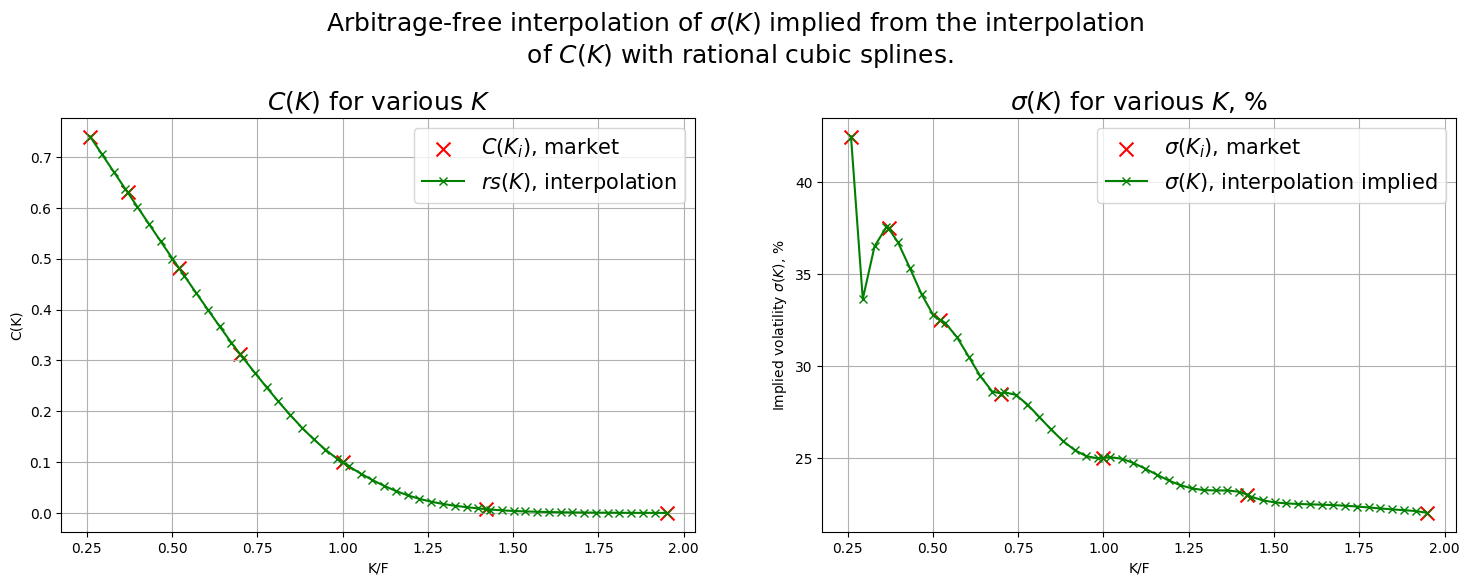

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness_wide_range, calls_wide_range,
              label="$C(K_i)$, market", marker="x", color="red", s=100)
ax[0].plot(dense_grid, interpolated_calls_rs(dense_grid),
           label="$rs(K)$, interpolation", marker="x", color="green")
ax[1].scatter(moneyness_wide_range, vol_wide_range * 100,
              label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
ax[1].plot(dense_grid, implied_vols_via_rs_prices_interpolation * 100,
           label="$\sigma(K)$, interpolation implied", marker="x", color="green")

plt.suptitle("Arbitrage-free interpolation of $\sigma(K)$ implied from the interpolation \n of $C(K)$ with rational cubic splines.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C(K)$ for various $K$'), ax[0].set_xlabel(
    'K/F'), ax[0].set_ylabel('C(K)'), ax[0].legend()
ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel(
    'K/F'), ax[1].set_ylabel('Implied volatility $\sigma(K)$, %'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

### Interpolated price via vol

In [18]:
ivs_slopes = slopes_estimation(
    x=np.log(moneyness_wide_range),
    y=vol_wide_range
)
r = r_boundary(d=ivs_slopes, f=vol_wide_range, x=np.log(moneyness_wide_range))

interpolated_vols = RationalCubicSplineInterpolator(
    x=np.log(moneyness_wide_range), y=vol_wide_range, r=r, d=ivs_slopes
)
interpolated_vols_dense_grid = interpolated_vols(np.log(dense_grid))

interpolated_calls_ns_via_vols_interpolation = black(
    log_moneyness=np.log(dense_grid),
    forward=forward,
    vol=interpolated_vols_dense_grid,
    df=df, T=T, theta=1
)

In [19]:
convexity_arbitrage(
    c=interpolated_calls_ns_via_vols_interpolation, k=dense_grid*forward
)
monotonicity_arbitrage(
    c=interpolated_calls_ns_via_vols_interpolation, k=dense_grid*forward
)

No arbitrage was detected.
No arbitrage was detected.


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/1540235172.py:9: SyntaxWarning: invalid escape sequence '\s'
  label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/1540235172.py:14: SyntaxWarning: invalid escape sequence '\s'
  "Arbitrage-free interpolation of $\sigma(K)$ with rational cubic splines.")
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/1540235172.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel(
/va

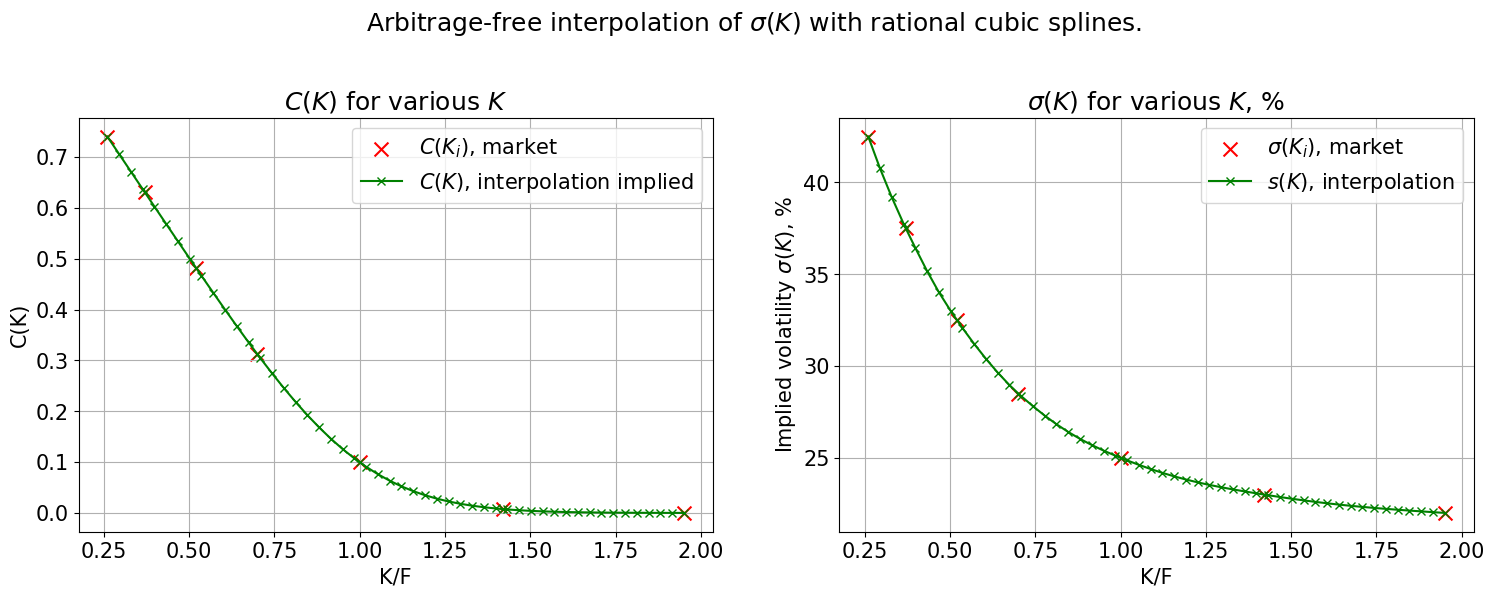

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness_wide_range, calls_wide_range,
              label="$C(K_i)$, market", marker="x", color="red", s=100)
ax[0].plot(dense_grid, interpolated_calls_ns_via_vols_interpolation,
           label="$C(K)$, interpolation implied", marker="x", color="green")
ax[1].scatter(moneyness_wide_range, vol_wide_range * 100,
              label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
ax[1].plot(dense_grid, interpolated_vols_dense_grid * 100,
           label="$s(K)$, interpolation", marker="x", color="green")

plt.suptitle(
    "Arbitrage-free interpolation of $\sigma(K)$ with rational cubic splines.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C(K)$ for various $K$'), ax[0].set_xlabel(
    'K/F'), ax[0].set_ylabel('C(K)'), ax[0].legend()
ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel(
    'K/F'), ax[1].set_ylabel('Implied volatility $\sigma(K)$, %'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

In [21]:
def numerical_derivative(f, h):
    def derivative_f(x):
        return (f(x + h) - f(x)) / h
    return derivative_f


def derivative(f, x, h):
    return (f(x + h) - f(x)) / h


def derivative_2(f, x, h):
    return (f(x + h) - 2 * f(x) + f(x - h)) / h**2


df_dlogm = numerical_derivative(interpolated_vols, 1e-3)
d2f_dlogm2 = numerical_derivative(interpolated_vols, 1e-3)


df_dlogm = df_dlogm(dense_grid)
d2f_dlogm2 = d2f_dlogm2(dense_grid)

In [22]:
density = breeden_litzenberger_density(
    f=interpolated_vols_dense_grid,
    df_dlogm=df_dlogm,
    d2f_dlogm2=d2f_dlogm2,
    moneyness=dense_grid,
    forward=forward
)

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/517084709.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(dense_grid, density, label="$\psi_{BBL} = C''(K_i)$")
/var/folders/rz/q38y2crj2378lqt648zw0cbr0000gn/T/ipykernel_5242/517084709.py:9: SyntaxWarning: invalid escape sequence '\p'
  "Breeden-Litzenberger density $\psi_{BBL}$, derived from implied volatilities $\sigma(K_i)$ interpolation.")


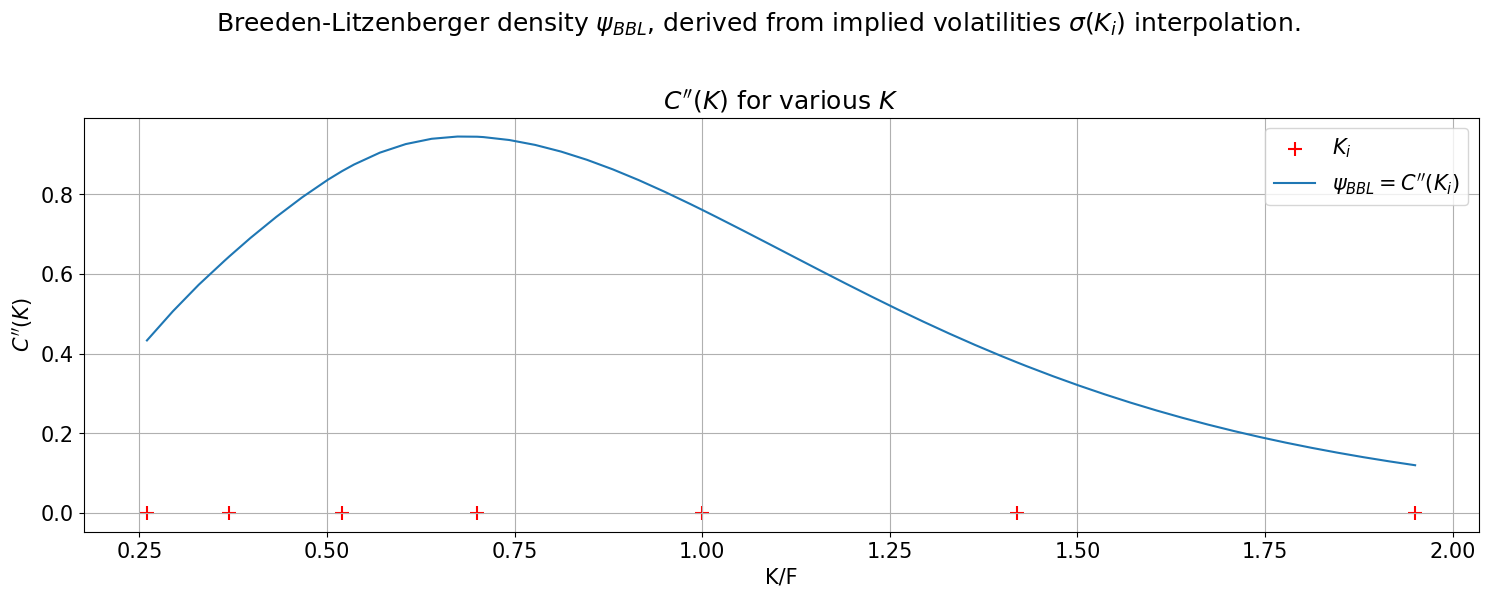

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax.scatter(moneyness_wide_range, np.zeros_like(
    moneyness_wide_range), label="$K_i$", marker="+", color="red", s=100)
ax.plot(dense_grid, density, label="$\psi_{BBL} = C''(K_i)$")

plt.suptitle(
    "Breeden-Litzenberger density $\psi_{BBL}$, derived from implied volatilities $\sigma(K_i)$ interpolation.")
plt.subplots_adjust(top=0.8)
ax.set_title('$C\'\'(K)$ for various $K$'), ax.set_xlabel(
    'K/F'), ax.set_ylabel('$C\'\'(K)$'), ax.legend()
ax.grid()
plt.show()

### 4. Pricing options within finite-differencing framework

Your task is to price European/American options within finite-differencing approach. You may assume you are given an implied volatilities (together with your interpolation method) from the previous task. 

1. Price within a finite-differencing method a European put option with strike $K=70\%$ and a European call option with strike $K = 130\%$. Use any numerical scheme you wish. Compare your results with the ones obtained analytically from Black-Scholes formula. How your results differ from the analytic ones?

2. Price within a finite-differencing method an American put option with strike $K=70\%$. Please note that an American option can be exercised at any time before the maturity if its intrinsic value is greater than calculated option price at that step. Use any numerical scheme you wish. Please describe the way how option's "American" property affects your finite-differencing algorithm when you are stepping in time. How its price differs from the price of European option with the same strike? 

You may use your own implementation of finite differencing algorithm or the one presented on the seminar.

### 1. European options

In [24]:
import numpy as np
from scipy.stats import norm
from scipy.sparse.linalg import splu, spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from pde_solver import solve_1d_pde, FiniteDifferencingScheme
from pricer import price, OptionType
from typing import Union

In [59]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float],
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))

In [92]:
print(strikes)
interpolated_vols(np.log(strikes/spot))

[ 70. 130.]


array([0.285     , 0.23379048])

In [61]:
number_of_time_steps = 31
finite_differencing_spacial_levels = 51
number_of_std_deviations = 4
scheme_type = FiniteDifferencingScheme.Explicit
number_of_spatial_levels, number_of_time_steps = 201, 201

spot = 100.
r = 0.0
sigma = 0.285
# maturities = np.array([1/12, 3/12, 6/12, 1])
maturities = np.linspace(1/12, 1, 10)

strikes = np.linspace(spot * 0.7, spot * 1.3, 2)


def pde_coefficients(_): return {
    "U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}


print(strikes)
trade_values_calls = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_calls_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))

for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        trade_values_calls[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.CALL,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)

        trade_values_calls_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot *
                                                  np.exp(r * maturity),
                                                  vol=sigma,
                                                  df=np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=1)

        trade_values_puts[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                        number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                        pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                        volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)

        trade_values_puts_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                 forward=spot *
                                                 np.exp(r * maturity),
                                                 vol=sigma,
                                                 df=np.exp(-r * maturity),
                                                 T=maturity,
                                                 theta=-1)

[ 70. 130.]


In [108]:
maturity = 1
spot = 1
strike = spot * 0.7
sigma = 0.23379048
scheme_type = FiniteDifferencingScheme.Implicit

print("Call")
print("Spot = ", spot)
print("Strike = ", strike)
print("Vol = ", sigma)
print("Maturity = ", maturity)
for r in [-0.2, 0.0, 0.2]:
    print("r = ", r)
    print(
        "Finite-differencing = ", price(maturity=maturity, strike=strike, option_type=OptionType.CALL,
                                        number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                        pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                        volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
    )

    print("Analytic = ", black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                               forward=spot *
                               np.exp(r * maturity),
                               vol=sigma,
                               df=np.exp(-r * maturity),
                               T=maturity,
                               theta=1)
          )

Call
Spot =  1
Strike =  0.7
Vol =  0.23379048
Maturity =  1
r =  -0.2
Finite-differencing =  0.1773370749785524
Analytic =  0.17737317323945245
r =  0.0
Finite-differencing =  0.30539304562205616
Analytic =  0.3053791644887617
r =  0.2
Finite-differencing =  0.4274079200530538
Analytic =  0.42739526979237696


In [109]:
spot = 1
maturity = 1
strike = spot*1.3
sigma = 0.285
print("Put")
print("Spot = ", spot)
print("Strike = ", strike)
print("Vol = ", sigma)
print("Maturity = ", maturity)
for r in [-0.2, 0.0, 0.2]:
    print("r = ", r)
    print(
        "Finite-differencing = ", price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                        number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                        pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                        volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
    )

    print("Analytic = ", black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                               forward=spot *
                               np.exp(r * maturity),
                               vol=sigma,
                               df=np.exp(-r * maturity),
                               T=maturity,
                               theta=-1)
          )

Put
Spot =  1
Strike =  1.3
Vol =  0.285
Maturity =  1
r =  -0.2
Finite-differencing =  0.5957460880839107
Analytic =  0.5956814211923191
r =  0.0
Finite-differencing =  0.33125786017609854
Analytic =  0.33122623848284927
r =  0.2
Finite-differencing =  0.15183661707989737
Analytic =  0.15190496827322175


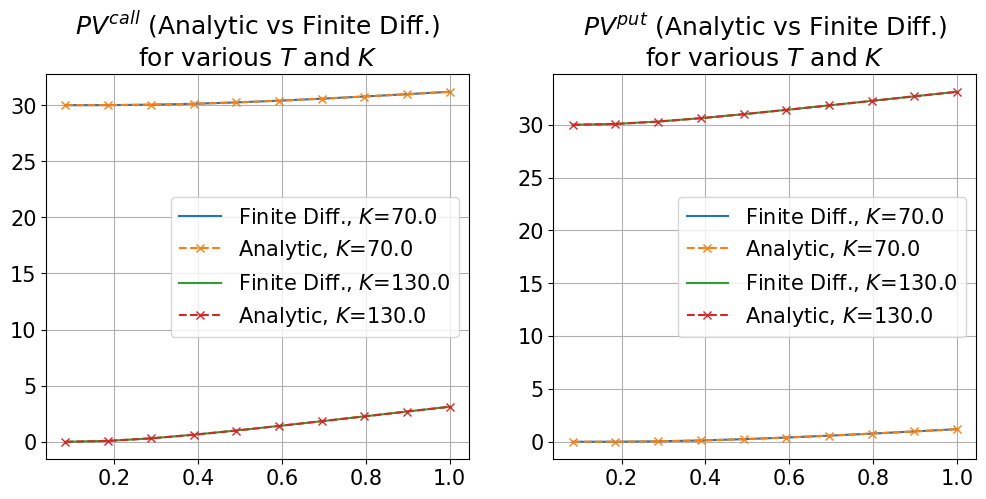

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, _ in enumerate(strikes):
    ax[0].plot(maturities, trade_values_calls[:, i],
               label="Finite Diff., $K$={}".format(_), linestyle="-")
    ax[0].plot(maturities, trade_values_calls_analytic[:, i],
               label="Analytic, $K$={}".format(_), linestyle="--", marker="x")

    ax[1].plot(maturities, trade_values_puts[:, i],
               label="Finite Diff., $K$={}".format(_), linestyle="-")
    ax[1].plot(maturities, trade_values_puts_analytic[:, i],
               label="Analytic, $K$={}".format(_), linestyle="--", marker="x")

ax[0].set_title(
    '$PV^{call}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$')
ax[1].set_title('$PV^{put}$ (Analytic vs Finite Diff.)\n' +
                'for various $T$ and $K$')
ax[0].grid(), ax[1].grid()
ax[0].legend(), ax[1].legend()
plt.show()

In [63]:
trade_values_puts_analytic[0, 1]

np.float64(30.001808838154986)

In [64]:
trade_values_puts[0, 1]

np.float64(30.00196003794587)

In [65]:
print(trade_values_puts_analytic[0, 1] - trade_values_puts[0, 1])
print(trade_values_calls_analytic[0, 1] - trade_values_calls[0, 1])

-0.00015119979088495938
-0.00015436871548151062


### 2. American options

Я посмотрел в Willmot Introduces Quantiative Finance, 2007, page 572.

In [87]:
number_of_time_steps = 31
finite_differencing_spacial_levels = 51
number_of_std_deviations = 4
scheme_type = FiniteDifferencingScheme.Implicit
number_of_spatial_levels, number_of_time_steps = 201, 201

spot = 100.0
r = 0.2
sigma = 0.285
# maturities = np.array([1/12, 3/12, 6/12, 1])
maturities = np.linspace(1/12, 1, 10)
strikes = np.linspace(spot * 0.7, spot * 1.3, 2)


def pde_coefficients(_): return {
    "U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}


def get_callPrice_from_parity(
    pricePut: float,
    strike: float,
    interest_rate: float,
    time_to_maturity: float,
    spot: float
) -> float:
    # не работает для американских опционов
    return pricePut + spot - strike*np.exp(-interest_rate*time_to_maturity)


print(strikes)
trade_values_puts_american = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts_european = np.zeros((maturities.shape[0], strikes.shape[0]))

trade_values_calls_american = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_calls_european = np.zeros((maturities.shape[0], strikes.shape[0]))

for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        trade_values_puts_american[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                                 number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                                 pde_coefficients=pde_coefficients, scheme=FiniteDifferencingScheme.AmericanPut, spot=spot,
                                                 volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)

        trade_values_puts_european[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                 forward=spot *
                                                 np.exp(r * maturity),
                                                 vol=sigma,
                                                 df=np.exp(-r * maturity),
                                                 T=maturity,
                                                 theta=-1)

        trade_values_calls_american[i][j] = get_callPrice_from_parity(
            pricePut=trade_values_puts_american[i][j],
            strike=strike,
            interest_rate=r,
            time_to_maturity=maturity,
            spot=spot
        )
        trade_values_calls_european[i][j] = get_callPrice_from_parity(
            pricePut=trade_values_puts_european[i][j],
            strike=strike,
            interest_rate=r,
            time_to_maturity=maturity,
            spot=spot
        )

[ 70. 130.]


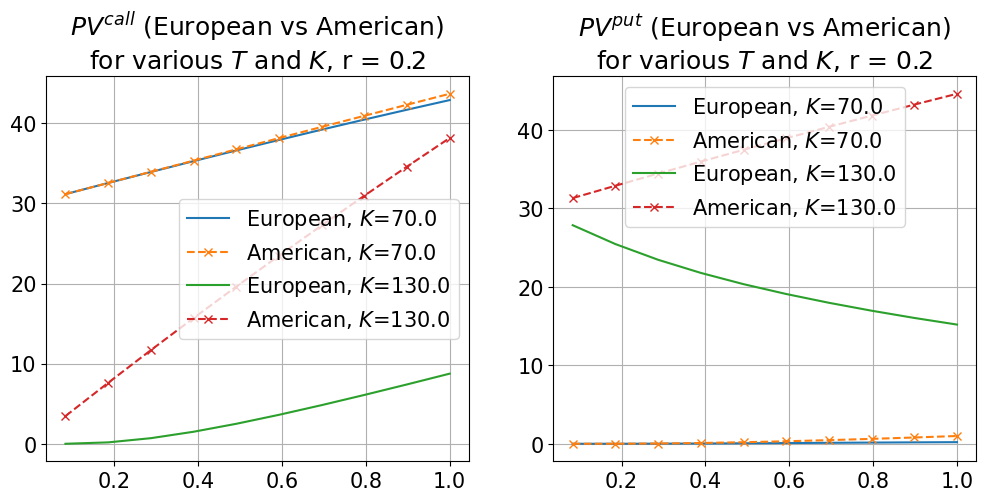

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, _ in enumerate(strikes):
    ax[0].plot(maturities, trade_values_calls_european[:, i],
               label="European, $K$={}".format(_), linestyle="-")
    ax[0].plot(maturities, trade_values_calls_american[:, i],
               label="American, $K$={}".format(_), linestyle="--", marker="x")

    ax[1].plot(maturities, trade_values_puts_european[:, i],
               label="European, $K$={}".format(_), linestyle="-")
    ax[1].plot(maturities, trade_values_puts_american[:, i],
               label="American, $K$={}".format(_), linestyle="--", marker="x")

ax[0].set_title(
    '$PV^{call}$ (European vs American)\n' + 'for various $T$ and $K$, r = {}'.format(r))
ax[1].set_title('$PV^{put}$ (European vs American)\n' +
                'for various $T$ and $K$, r = {}'.format(r))
ax[0].grid(), ax[1].grid()
ax[0].legend(), ax[1].legend()
plt.show()

In [89]:
print(trade_values_puts_american[0, 1] - trade_values_puts_european[0, 1])

3.4535981465431753


In [90]:
trade_values_puts_american[1, 1]

np.float64(32.884413569657724)

In [91]:
trade_values_puts_european[1, 1]

np.float64(25.451329953982203)